# FWI in practice


In the previous tutorials, we have highlighted the capabilities of JUDI and the different available tools and operators. However, in practice, FWI requires to use those together in a workflow that contains

- **Frequency sweep**: A low-to-high frquency sweep that invert for low-pass filtered data with increasing frequency cutoff. This allow to reduce cycle skipping issues as the misfit function is usually "more convex" at lower frequencies. Since lower frequencies also lead to coarser grid sizes, this reduces the overall computationnal cost
- **Reciprocity**: One of the main cost reduction for acquisitions such as OBN is to apply geometry to reduce the number of independent source experiment by an order of magnitude.
- **Hessian approximation**: Apllying an approximation of the Hessian usually leads to a better update direction and faster convergence. So most simple one would be a simple depth scaling. More advanced approximation include illumination correction (that we will use), Gauss-Newton update or other approximation.


## A didactic walktrhough

We will now provide a didactic walkthrough inversion. For simplicity we willd othe following

- 1. Generate synthectic data. THis will help the inversion as we will have much cleaner data than in the field case
- 2.Create an initial background model by smoothing the true model. In practice, for field data, this would not be possible as the true model is unknown. Traditional methods would then be needed such as NMO velocity picking.
    - 2.b Compare the data in the background with the true data for cycle skipping
- 3. Setup the frequency sweep. We will setup the linear operators to be used,  the model up/downsamplign operators and the frequency bands.
- 4. Setup the optimization with Projected Quasi-Newton and define physically realistics bounds on the model
- 5. Run the inversion
- 6. Check the result and compare the data in the final model and for the intermediate model for each frquency band

**Packages**
Let's import all the packages we will use in this tutorial. 

In [1]:
using JUDI   # Wave-equation inversion framework
using SegyIO  # for SEGY files.
using JLD2   # For JLD2 files
using SlimPlotting   # Plotting utilities
using SlimOptim   # Inversion algorithms (spg, pqn, Linearized Bregman)
using HDF5  # HDF5 file io
using Random  # For shot subsampling
using LinearAlgebra # Standard LA librairy (norm , ...) 

[ Info: Precompiling JUDI [f3b833dc-6b2e-5b9c-b940-873ed6319979]


## Synthetic setup

Let's setup the synthetic model and data. We will use a default Ocean Bottom Node acquistion for simplicity

In [2]:
if ~isfile("$(JUDI.JUDI_DATA)/marmousi_model.h5")
    ftp_data("ftp://slim.gatech.edu/data/SoftwareRelease/Imaging.jl/2DLSRTM/marmousi_model.h5")
end
n, d, o, m = read(h5open("$(JUDI.JUDI_DATA)/marmousi_model.h5", "r"), "n", "d", "o", "m")

([1599, 639], [5.0, 5.0], Float32[0.0, 0.0], Float32[0.44444445 0.44444445 … 0.054083288 0.054083288; 0.44444445 0.44444445 … 0.054083288 0.054083288; … ; 0.44444445 0.44444445 … 0.069742806 0.06925208; 0.44444445 0.44444445 … 0.07239276 0.06925208])

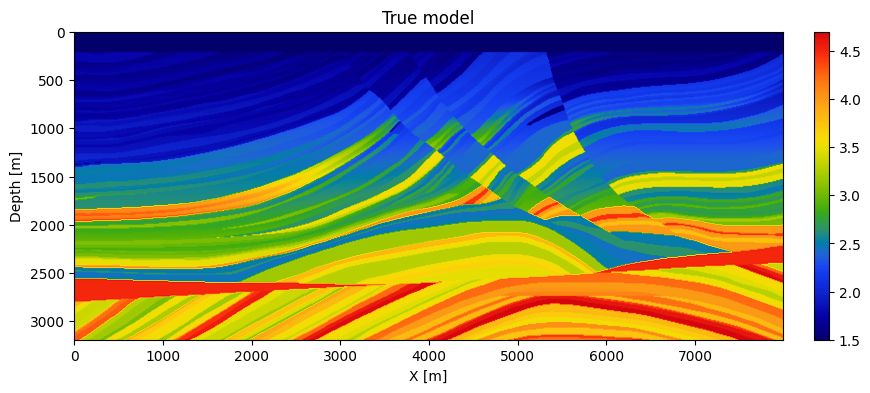

In [3]:
figure(figsize=(10, 4))
plot_velocity(m'.^(-.5), d; cbar=true, new_fig=false, name="True model")

In [4]:
# Create the model. We add a lot of absorbing layer points to have clean synthetic data
model = Model(n, d, o, m; nb=120);

In [5]:
# Data sampling rate and recording time
timeD = 4000f0   # receiver recording time [ms]
dtD = 4f0    # receiver sampling interval [ms]

4.0f0

In [6]:
# setup wavelet
f0 = 0.03f0     # kHz
wavelet = ricker_wavelet(timeD, dtD, f0);

One of the most common mistake with synthetic data in seismic is to keep very low frequencies that cannot be acquired in the field and make the inversion much easier. We remove those low frequencies to make our synthetic dataset realistic

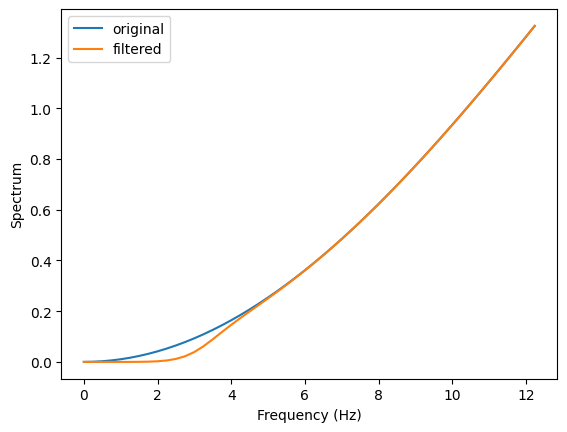

PyObject <matplotlib.legend.Legend object at 0x288836110>

In [7]:
waveletf = filter_data(wavelet, dtD; fmin=3.5f0)
freqs = JUDI.FFTW.fftfreq(length(wavelet),  1/(1f-3*dtD))
plot(freqs[1:50], abs.(JUDI.fft(wavelet))[1:50], label="original")
plot(freqs[1:50], abs.(JUDI.fft(waveletf))[1:50], label="filtered")
xlabel("Frequency (Hz)")
ylabel("Spectrum")
legend()

We now create the obn geometry. We set the OBN to be 200m apart 

In [8]:
wb = find_water_bottom(m);

In [9]:
# One source every 25m at the surface (8m depth)
xsrc = 0f0:12.5f0:(n[1] - 1) * d[1]
zsrc = 8f0 * ones(Float32, length(xsrc));
nsrc = length(xsrc)
srcGeom = Geometry(convertToCell(xsrc), convertToCell(zsrc); dt=dtD, t=timeD)
# One OBN every 200m
xrec = 0f0:200f0:(n[1] - 1) * d[1]
zrec = Float32.((wb[1:40:end] .- 1) * d[2]);
recGeom = Geometry(xrec, zrec; dt=dtD, t=timeD, nsrc=nsrc)

GeometryIC{Float32} wiht 640 sources


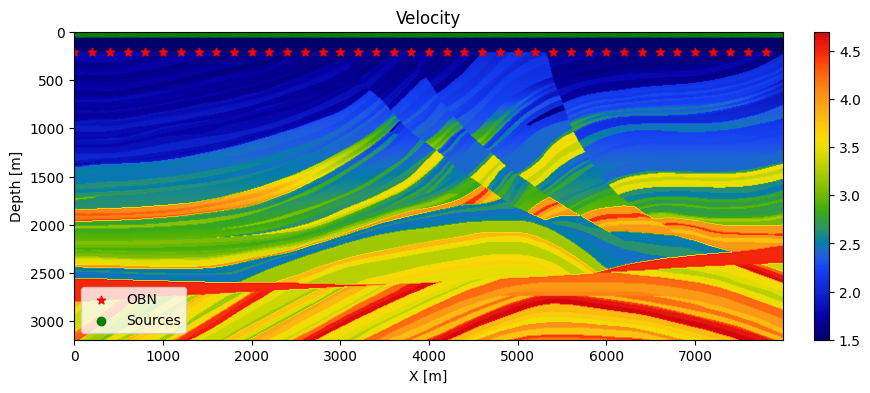

PyObject <matplotlib.legend.Legend object at 0x288912050>

In [10]:
figure(figsize=(10, 4))
plot_velocity(m'.^(-.5), d; cbar=true, new_fig=false)
scatter(xrec, zrec, marker="*", color="r", label="OBN")
scatter(xsrc, zsrc, marker="o", color="g", label="Sources")
legend()

#### Reciprocity

As mentionned in the introduction, reciprocity allow to reduce the computational cost by treating the sources as receivers and vice versa. We can do it to generate the synthetic data as well

In [11]:
# Apply reciprocity
sGeomComp, rGeomComp = reciprocal_geom(srcGeom, recGeom)

(GeometryIC{Float32} wiht 40 sources, GeometryIC{Float32} wiht 40 sources)

### Linear operators
Now that we have our acquisition defined, we can create the linear operators we will be using for simulation and iversion.

In [12]:
q = judiVector(sGeomComp, wavelet)
F = judiModeling(model, sGeomComp, rGeomComp)

JUDI forward{Float32} propagator (src * rec * time) -> (src * rec * time)

### Synthetic data

In [13]:
d_obs = F*q

Building forward operator
Operator `forward` ran in 6.57 s
Operator `forward` ran in 6.69 s
Operator `forward` ran in 6.68 s
Operator `forward` ran in 6.68 s
Operator `forward` ran in 6.68 s
Operator `forward` ran in 6.66 s
Operator `forward` ran in 6.65 s
Operator `forward` ran in 6.69 s
Operator `forward` ran in 6.66 s
Operator `forward` ran in 6.67 s
Operator `forward` ran in 6.65 s
Operator `forward` ran in 6.65 s
Operator `forward` ran in 6.65 s
Operator `forward` ran in 6.64 s
Operator `forward` ran in 6.67 s
Operator `forward` ran in 6.66 s
Operator `forward` ran in 6.64 s
Operator `forward` ran in 6.66 s
Operator `forward` ran in 6.67 s
Operator `forward` ran in 6.63 s
Operator `forward` ran in 6.73 s
Operator `forward` ran in 6.66 s
Operator `forward` ran in 6.65 s
Operator `forward` ran in 6.64 s
Operator `forward` ran in 6.65 s
Operator `forward` ran in 6.67 s
Operator `forward` ran in 6.64 s
Operator `forward` ran in 6.66 s
Operator `forward` ran in 6.66 s
Operator `forward

judiVector{Float32, Matrix{Float32}} with 40 sources


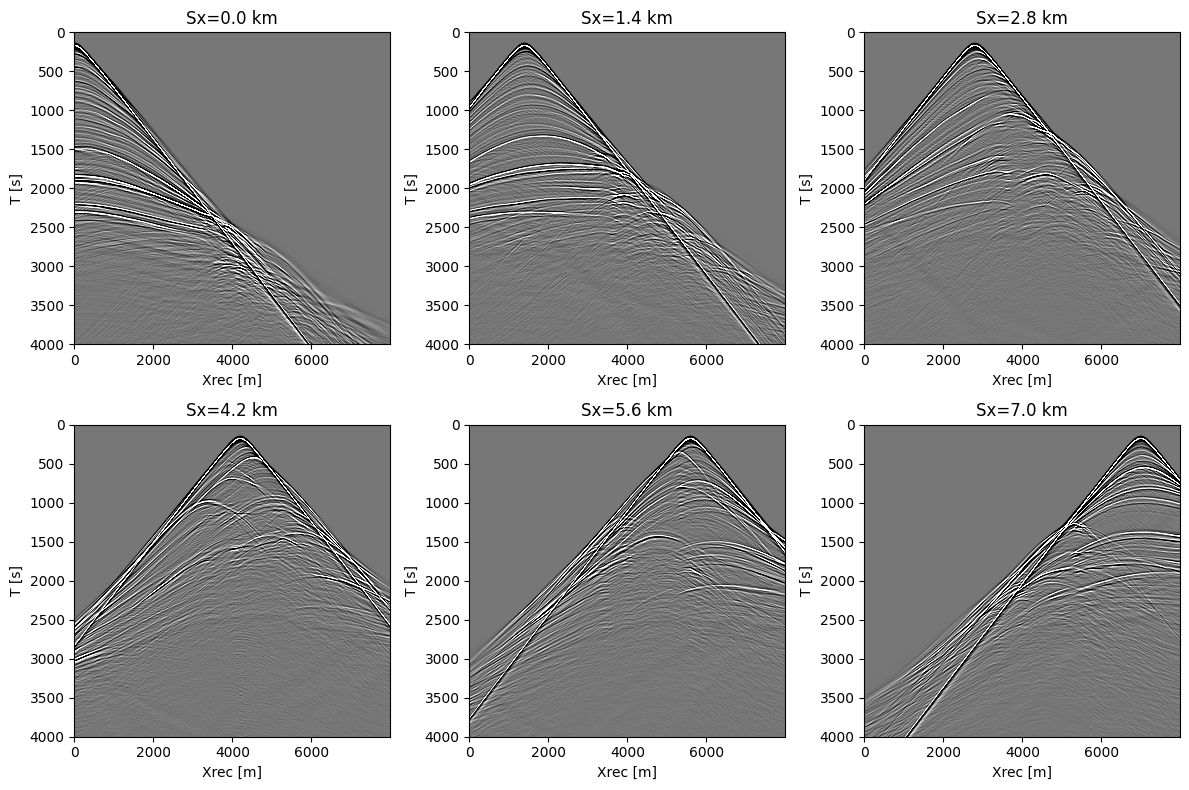

In [14]:
figure(figsize=(12, 8))
for (k, i) in enumerate(1:7:d_obs.nsrc)
    subplot(2,3,k)
    plot_sdata(d_obs[i]; new_fig=false, name="Sx=$(round(1f-3*q.geometry.xloc[i][1], digits=3)) km")
end
tight_layout()

### Background model

We now define our background model, starting point for the inversion. We take a fairly simplicstic bagroung model by taking the trace average (sum of all the vertical traces)

In [ ]:
using Images
m0 = 1 .* m
m0[:, wb[1]+1:end] .= 1 ./ imfilter(1 ./ m0[:, wb[1]+1:end], Kernel.gaussian((101, 101)));
model0 = Model(n, d, o, m0)

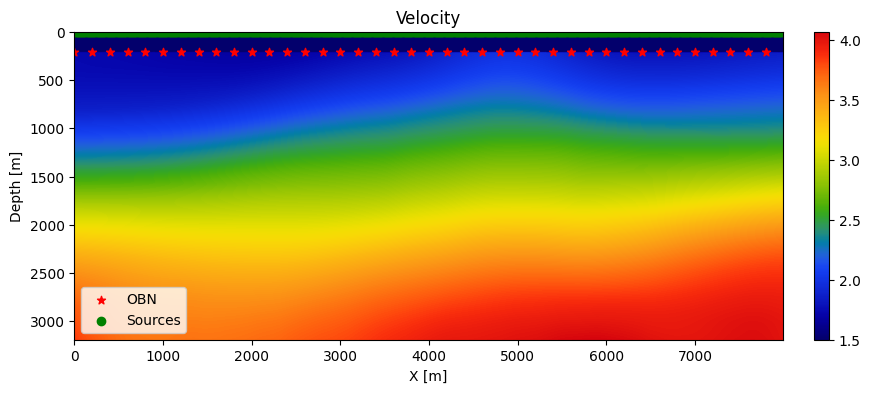

PyObject <matplotlib.legend.Legend object at 0x29ae1b710>

In [16]:
figure(figsize=(10, 4))
plot_velocity(m0'.^(-.5), d; cbar=true, new_fig=false)
scatter(xrec, zrec, marker="*", color="r", label="OBN")
scatter(xsrc, zsrc, marker="o", color="g", label="Sources")
legend()

Let's compute a shot in the background model to comapre with the synthetic data

In [17]:
d0 = F(model0)[10]*q[10]

LoadError: UndefVarError: `model0` not defined

In [18]:
plot(d_obs.data[10][1:150, 100])
plot(d0.data[1][1:150, 100])

LoadError: UndefVarError: `d0` not defined

In [19]:
figure(figsize=(10, 10))
compare_shots(d0, d_obs[10]; side_by_side=true, new_fig=false)
figure(figsize=(10, 10))
plot_sdata(d0 - d_obs[10];  new_fig=false)

LoadError: UndefVarError: `d0` not defined

In [20]:
step = div(d0.geometry.nrec[1], 5)
time = 0:dtD:timeD
starts = trunc.(Int, (1000/dtD, 1, 800/dtD, 1750/dtD, 2500/dtD))
ends = trunc.(Int, (1500/dtD, 1000/dtD, 1500/dtD, 2500/dtD, 3500/dtD))
figure(figsize=(16, 16))
for (k, i) in enumerate(1:step:d0.geometry.nrec[1])
    subplot(5,1,k)
    plot(time[starts[k]:ends[k]], d_obs.data[10][starts[k]:ends[k], i], label="True")
    plot(time[starts[k]:ends[k]], d0.data[1][starts[k]:ends[k], i], label="Background")
    xlabel("Time (ms)")
end
tight_layout()

LoadError: UndefVarError: `d0` not defined

## Inversion

### Setup freq sweep

In [21]:
freqs = [5, 8, 12, 15, 20]
batchsize = d_obs.nsrc;

Let's look at the data for each frequency 

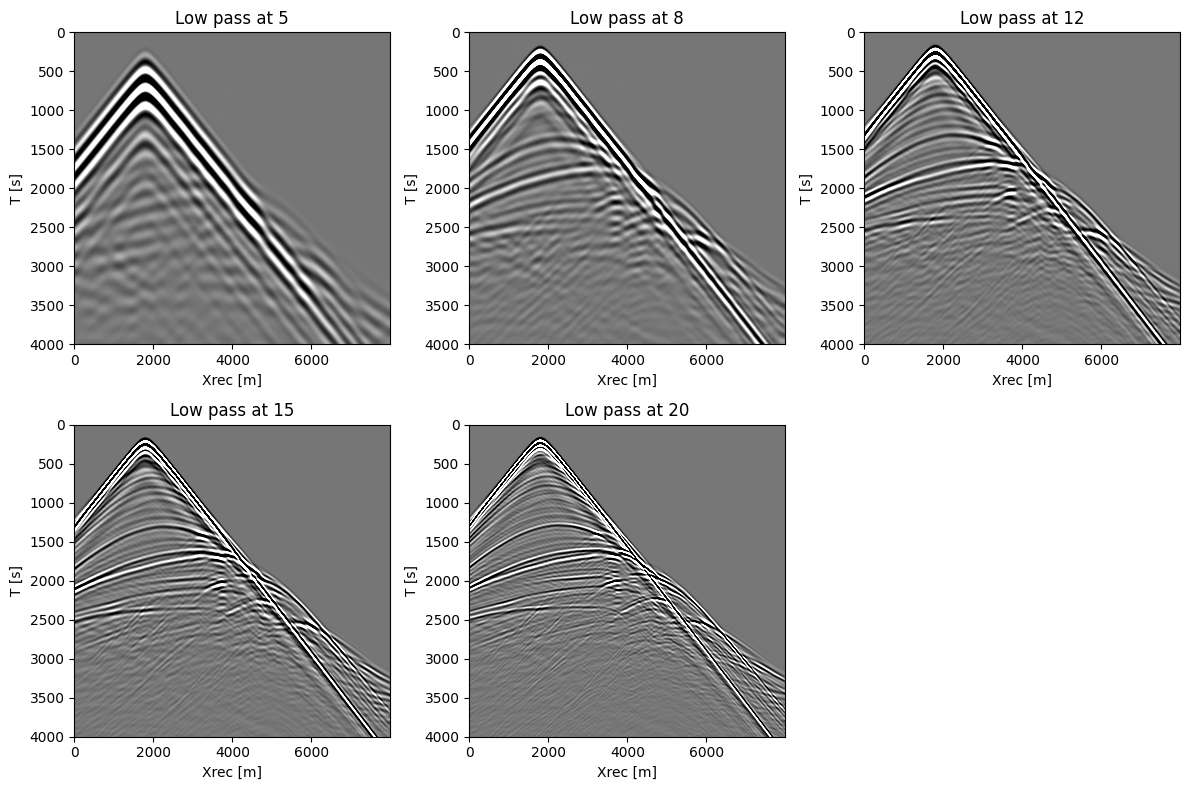

In [22]:
figure(figsize=(12, 8))
for (k, f) in enumerate(freqs)
    subplot(2,3,k)
    plot_sdata(filter_data(d_obs[10]; fmin=3, fmax=f); new_fig=false, name="Low pass at $(f)")
end
tight_layout()

## Setup PQN

In [23]:
feval = 5
spgopt = spg_options(verbose=1, memory=3, maxIter=feval)

SlimOptim.SPG_params(1, 1.0f-10, 1.0f-10, 5, 1.0f-8, 3, true, false, false, true, true, false, false, Inf, 1, 20)

In [24]:
# Objective function for minConf library
g_const = 0
function objective_function(modeli, x, freq)
    modeli.m .= reshape(x,modeli.n);
    M = judiTopmute(modeli; taperwidth=1)
    Il = inv(judiIllumination(modeli; mode="uv", k=1))

    # fwi function value and gradient
    i = randperm(d_obs.nsrc)[1:batchsize]
    fval, grad = fwi_objective(modeli, filter_data(q[i]; fmin=3, fmax=freq),
                               filter_data(d_obs[i]; fmin=3, fmax=freq);
                               options=Options(IC="fwi"))
    grad = Il*M*grad
    g_const == 0 && (global g_const = norm(grad, Inf)*10)
    grad ./= g_const  # scale for line search

    return fval, grad[1:end]
end


objective_function (generic function with 1 method)

In [25]:
# Bound projection
mmin, mmax = extrema(m)
function proj(x)
    out = 1 .* x
    out[out .< mmin] .= mmin
    out[out .> mmax] .= mmax
    return out
end
    

proj (generic function with 1 method)

In [26]:
m0coarse = m0[1:3:end, 1:3:end]
model0coarse = Model(size(m0coarse), d.*3, o, m0coarse)

Model (n=(533, 213), d=(15.0f0, 15.0f0), o=(0.0f0, 0.0f0)) with parameters [:m, :rho]

### Look at the first gradient

In [27]:
g_const = 0
f, g = objective_function(model0coarse, m0[1:3:end, 1:3:end][:], freqs[1])

┌ Warning: Deprecated model.n, use size(model)
│   caller = ip:0x0
└ @ Core :-1
Building forward operator
Operator `forward` ran in 0.59 s
Building adjoint born operator
Operator `gradient` ran in 8.14 s
Operator `forward` ran in 0.31 s
Operator `gradient` ran in 8.06 s
Operator `forward` ran in 0.31 s
Operator `gradient` ran in 8.30 s
Operator `forward` ran in 0.33 s
Operator `gradient` ran in 8.27 s
Operator `forward` ran in 0.33 s
Operator `gradient` ran in 8.28 s
Operator `forward` ran in 0.34 s
Operator `gradient` ran in 8.18 s
Operator `forward` ran in 0.33 s
Operator `gradient` ran in 9.18 s
Operator `forward` ran in 0.45 s
Operator `gradient` ran in 8.25 s
Operator `forward` ran in 0.31 s
Operator `gradient` ran in 8.17 s
Operator `forward` ran in 0.34 s
Operator `gradient` ran in 8.03 s
Operator `forward` ran in 0.32 s
Operator `gradient` ran in 7.97 s
Operator `forward` ran in 0.32 s
Operator `gradient` ran in 8.03 s
Operator `forward` ran in 0.33 s
Operator `gradient` ran in

LoadError: type Int64 has no field data

In [28]:
figure(figsize=(12, 8))
subplot(211)
plot_simage(reshape(g, model0coarse.n)', model0coarse.d; cmap="seismic", cbar=true, new_fig=false)
subplot(212)
plot_simage(reshape(m0coarse - m[1:3:end, 1:3:end], model0coarse.n)', model0coarse.d; cmap="seismic",
            cbar=true, perc=99, new_fig=false)
tight_layout()

LoadError: UndefVarError: `g` not defined

## Run inversion

In [ ]:
# Turn off all the `Operator ... ran in` for cleanr spg log
set_devito_config("log-level", "ERROR")
sols = []
for f in freqs[1:2]
    global g_const = 0
    global m0loc = model0coarse.m[1:end]
    minfunc = x -> objective_function(model0coarse, x, f)
    solf = spg(minfunc, m0loc, proj, spgopt)
    push!(sols, solf)
end

## Plot results

In [ ]:
ninv = length(sols)
figure(figsize=(10, 4*(ninv+1)))
subplot(ninv+1, 1, 1)
plot_velocity(m0[1:3:end, 1:3:end]'.^(-.5), d; cbar=true, new_fig=false)
for i=1:ninv
    subplot(ninv+1, 1, i+1)
    plot_velocity(reshape(sols[i].x, model0coarse.n)'.^(-.5), d; cbar=true, new_fig=false, name="$(freqs[i]) Hz")
end
tight_layout()

## Compare data

## CIG for QC